In [1]:
from scipy.special import comb
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from itertools import product

from sklearn.model_selection import GridSearchCV

In [2]:
# Calculate the error rate of an ensemble of classifiers.
# The classifier are independent of each other.
# The ensemble is regarded as making a mistake if over half of the classifiers make mistakes.
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier/2))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier-k) for k in range(k_start, n_classifier+1)]
    return sum(probs)

In [3]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [4]:
error_range = np.arange(0, 1, 0.01)
ensemble_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

Text(0.5, 0, 'Individual Error')

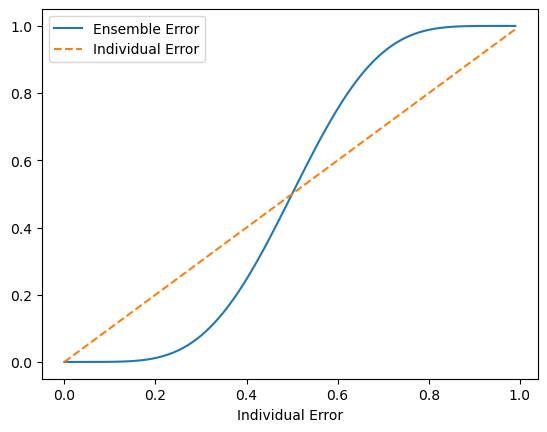

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(error_range, ensemble_errors, label='Ensemble Error')
ax.plot(error_range, error_range, label='Individual Error', linestyle="--")
ax.legend()

ax.set_xlabel("Individual Error")

In [6]:
# A simple implementation of majority vote
# Consider an ensemble of 3 classifiers. C1 and C2 predict 0, and C3 predict 1.
predictions = [0, 0, 1]
num_occurrences = np.bincount(predictions) # 'bincount' counts the number of occurrences of each value in 'predictions'
maj_vot = np.argmax(num_occurrences) # 'argmax' returns the index the maximum value.
print(f"Majority Vote: {maj_vot}") 

Majority Vote: 0


In [7]:
# Now we assign weights to the classifiers
weights = [0.1, 0.1, 0.3]
num_occurrences = np.bincount(predictions, weights=weights)
# When weighted, bincount calculates the weighted occurrence.
# The prediction of C1 is 0 and its weight is 0.1. Therefore, num_occurrences[0] += 0.1
print(f'num_occurrences: {num_occurrences}')
maj_vot = np.argmax(num_occurrences)
print(f"Majority Vote: {maj_vot}") 

num_occurrences: [0.2 0.3]
Majority Vote: 1


In [8]:
# Now we assign different weights to the classifiers
weights = [0.1, 0.2, 0.3]
num_occurrences = np.bincount(predictions, weights=weights)
print(f'num_occurrences: {num_occurrences}')
maj_vot = np.argmax(num_occurrences)
print(f"Majority Vote: {maj_vot}") 
#In case of multiple occurrences of the maximum values, the index corresponding to the first occurrence are returned.

num_occurrences: [0.3 0.3]
Majority Vote: 0


Implementing majority vote by using the class probabilities   
$$y=argmax_i\sum_{j}^{n_{classifier}} w_j p_{ij}$$
$$p_{ij}=\Pr(\text{the class label is i, predicted by the jth classifier})$$

In [9]:
# Implementation
# Binary classification, 3 classifiers.
# Class probabilities for each classifier is in a row
probs_class = np.array([
    [0.9, 0.1],
    [0.8, 0.2],
    [0.4, 0.6]
])
# Without weights on the classfiers
probs_pred = np.average(probs_class, axis=0)

In [10]:
probs_pred

array([0.7, 0.3])

In [11]:
# With weights
probs_pred = np.average(probs_class, axis=0, weights=[0.2, 0.2, 0.6])
probs_pred

array([0.58, 0.42])

In [12]:
# Majority vote
np.argmax(probs_pred)

0

In [13]:
# Majority vote classifier
# Note that its usage is just the same as Logistic regression, SVC and so on.
# It has fit, predict, predict_proba methods.
# Inheritance from BaseEstimator, ClassifierMixin
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote="classlabel", weights=None):
        # List of classifiers
        self.classifiers = classifiers
        # _name_estimators: returns a list of 2-tuples
        # Each tuple has the format (classifier name, classifier object)
        # Thus, self.named_classifiers stores all the classifiers as a dictionary
        # Each entry in the dictionary is classifier name: classifier object
        self.named_classifiers = {key:value  for key,value in _name_estimators(classifiers)}
        # self.vote only has two options: "classlabel", "probability"
        self.vote = vote 
        self.weights = weights # Weights of the classifiers
    
    def fit(self, X, y):
        # This function fits all classifiers in self.classifiers.
        # Only two options are allowed for majority vote.
        if self.vote not in ('probability', 'classlabel'):
            # Python strings will automatically concatenate when not separated by a comma
            raise ValueError(f"Vote must be 'probability'"
                             f"or 'classlabel'"
                             f"; got (vote={self.vote})"
                            )
        # The number of weights must be equal to the number of classifiers
        if self.weights and len(self.weights)!=len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights and {len(self.classifiers)} classifiers'
                            )
         
        
        # The perform majority vote, the class labels should be integers 0, 1, ...
        # LabelEncoder(): Encode target labels with value between 0 and n_classes-1
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        # self.classes_ stores all possible labels
        self.classes_ = self.lablenc_.classes_
        # self.classifiers_: used to store fitted classifiers, see below
        self.classifiers_ = []
        
        for clf in self.classifiers:
            # Fit each classifier without affecting the original classifier
            # Construct a new unfitted estimator with the same parameters.
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            # Store the fitted classifier
            self.classifiers_.append(fitted_clf)
            
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            # If X is a single example (1D array), the result is the predicted label for it.
            # If X includes multiple examples (2D array), the result is a 1D array
            # containing the predicted label for each example.
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            # clf.predict(X): the result is a 1D array of shape (n_samples,)
            # predictions: the result is a 2D array of shape (n_classifiers, n_samples)
            # After transposition, the shape becomes (n_samples, n_classifiers)
            # Each row contains the predictions of all classifiers about one example.
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            # apply_along_axis: apply a given function along a given axis
            # np.bincount(x, weights=self.weights): weighted count of predicted class labels
            # np.argmax(np.bincount(x, weights=self.weights): majority vote for example x
            # maj_vote: majority votes for each example
            maj_vote = np.apply_along_axis(
                            lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                            axis = 1, 
                            arr = predictions
            )
        # Transform to the original class label
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        # predict_proba(X):
        # X: array of shape (n_samples, n_features), each row represents a sample
        # output: array of shape (n_samples, n_classes), the class probabilities
        # np.asarray: clf.predict_proba(X) is a 2D array of shape (n_samples, n_classes)
        # np.asarray add a new dimension, the result is a 3D array of shape (n_classifiers, n_samples, n_classes)
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        # The average is taken along the first axis.
        # For a given sample and a specific class, the result is the average of the class probabilities 
        # of this sample being in that class predicted by all the classifiers.
        # Of course, if weights are specified, the average is weighted.
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    # Redefine get_params
    # Used in grid search
    def get_params(self, deep=True):
        # If deep == False, use the inherited get_params method
        # get_params(deep=True): retrieves all hyperparameters of the estimator, including those of any nested objects
        # get_params(deep=False): retrieves only the hyperparameters that were passed to the estimator directly
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [14]:
# Implement majority vote
# Load data
iris = datasets.load_iris()

In [15]:
# Only use two features
X = iris.data[50:, [1,2]]
y = iris.target[50:]

In [16]:
# Transform label to 0, 1
le = LabelEncoder()
y = le.fit_transform(y)

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [18]:
# Create 3 classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

In [19]:
# Decision tree can handle the original data, while the other two only work best with rescaled data
pipe1 = Pipeline([['sc', StandardScaler()],['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],['clf', clf3]])

In [20]:
# Cross validation
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation with ROC AUS as score:')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f}'
          f'(+/- {scores.std():.2f}) [{label}]')

10-fold cross validation with ROC AUS as score:
ROC AUC: 0.92(+/- 0.15) [Logistic regression]
ROC AUC: 0.87(+/- 0.18) [Decision tree]
ROC AUC: 0.85(+/- 0.13) [KNN]


In [21]:
clf4 = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
all_clf = [pipe1, clf2, pipe3, clf4]
clf_labels.append('Majority voting')
for clf, label in zip([pipe1, clf2, pipe3, clf4], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


Text(0, 0.5, 'True positive rate')

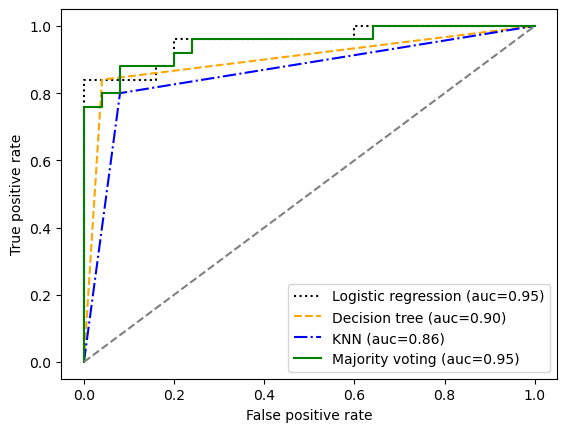

In [22]:
# ROC curve
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, color, ls in zip(all_clf, clf_labels, colors, linestyles):
    clf.fit(X_train, y_train)
    # Assume that the label of the positive class is 1
    # The class probabilities for this class are stored in the second column
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    ax.plot(fpr, tpr, color=color, linestyle=ls, label=f'{label} (auc={roc_auc:.2f})')

ax.legend()
ax.plot([0,1],[0,1], linestyle="--", color='gray')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\bai_f\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

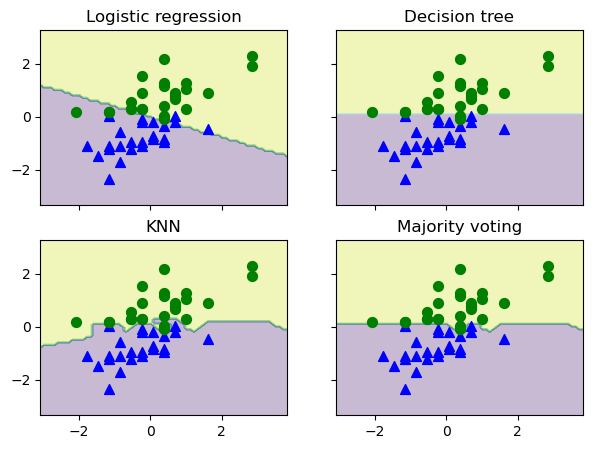

In [23]:
# Visualizing the decision boundary for each classifier
# Rescale data, so that the decision boundary for the decision tree classifier is shown on the same scale as the other two classifiers.
# Note that this is only for plotting. Decision tree can handle the original data without rescaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:,0].min() - 1 # x_min: min of the first feature - 1
x_max = X_train_std[:,0].max() + 1 # x_max: max of the first feature + 1

y_min = X_train_std[:,1].min() - 1 # y_min: min of the second feature - 1
y_max = X_train_std[:,1].max() + 1 # y_max: max of the second feature + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

fig, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))
# shrex='col': each column of figures share the x axis. Only the x ticklabels of the bottom figure in each column will be shown
# sharey='row': each row of figures share the y axis. Only y ticklabels of the leftmost figure will be shown

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    # product([0, 1], [0, 1]): create a iterable that essentially contains (0, 0), (0, 1), (1, 0), (1, 1)
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # xx.ravel(): flatten xx (2D-array) into a 1D array. Without specification, flattening is row by row (the second row is put after the first row and so on)
    # np.c_: use xx.ravel(), yy.ravel() as two columns to create a 2D array
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3) # Plot decision regions
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], color='blue', marker='^', s=50) #s: marker size in points**2
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], color='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)


In [24]:
# Tuning hyperparameters
clf4 # The majority vote classifier

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ['clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1)]]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ['clf',
                                                     KNeighborsClassifier(n_neighbors=1)]])])

In [25]:
clf4.get_params()
# The result contains the names of the parameters in the classifiers.
# These names can be used in grid search.

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [26]:
params = {'decisiontreeclassifier__max_depth': [1,2], 'pipeline-1__clf__C':[0.001, 0.1, 100]}
grid = GridSearchCV(estimator=clf4, param_grid=params, cv=10, scoring='roc_auc')

In [27]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                           

In [28]:
grid.cv_results_['mean_test_score']
# This stores the mean test score for all combinations of parameters
# 'Mean' refers to the average of cross-validation

array([0.98333333, 0.98333333, 0.96666667, 0.98333333, 0.98333333,
       0.96666667])

In [29]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']): # grid.cv_results_['mean_test_score'] is only used to get index. In fact, for r in grid.cv_results_['mean_test_score'].shape[0] is also ok
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.2f} +/- {std_dev:.2f}{params}')
                              

0.98 +/- 0.05{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.98 +/- 0.05{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.97 +/- 0.10{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.98 +/- 0.05{'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.98 +/- 0.05{'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.97 +/- 0.10{'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}


In [30]:
grid.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}

In [31]:
grid.best_score_

0.9833333333333334

In [32]:
grid.cv_results_['mean_test_score']

array([0.98333333, 0.98333333, 0.96666667, 0.98333333, 0.98333333,
       0.96666667])

In [33]:
grid.cv_results_['params']

[{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001},
 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1},
 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100},
 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001},
 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1},
 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}]